# Markov Chain for Campaign Attribution POC

In [1]:
import mta
import pandas as pd
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import seaborn as sns
from scipy.stats import pearsonr
# if you haven't alreadya GCP authenticated run !gcloud auth login
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

# data has been saved to the repo, if you want to redownload from GCP, set to True
REDOWNLOAD_FROM_GCP = 1

Visit http://www.channelattribution.net for more information about ChannelAttribution


Information about MTA module  
https://bitbucket.org/wx_rds/mta/src/50cd3c3f2469/?at=master  
https://bytebucket.org/wx_rds/mta/wiki/_build/latex/mta.pdf?token=ed3f93f21d7e08c5a92ba0abba35888f63412a54&rev=599fd6872540e9a4945b968e0f02a87c9fc15ea5  
https://www.channelattribution.net/assets/files/ChannelAttributionWhitePaper-0536c269c4725179d4a0d8b8ec2f0fac.pdf

## MC POC data

In [2]:
# grab data from GCP
if REDOWNLOAD_FROM_GCP:
    # alternative to reading from GCP directly into pandas dataframe, not working since MTA update
    !rm -f 02_data/MCPOC_input*.csv
    !gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_*.csv 02_data/

Copying gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_000000000000.csv...
Copying gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_000000000001.csv...  
Copying gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_000000000002.csv...  
\ [3 files][290.4 MiB/290.4 MiB]                                                
Operation completed over 3 objects/290.4 MiB.                                    


In [3]:
df = pd.DataFrame()
for f in glob.glob('02_data/MCPOC_input_*.csv'):
    df = df.append(pd.read_csv(f))

In [32]:
df.head()

wk_start_date                                               path  num_crn  \
0    2021-02-08                     CAT-4003_2021-01-28_activation        1   
1    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...        4   
2    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...       21   
3    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...        1   
4    2021-02-08  CAT-4003_2021-01-28_activation > CAT-4003_2021...        1   

   inc_sales  conversion_inc_sales_positive  \
0   -44.9073                              0   
1   207.5564                              4   
2  1180.4009                             19   
3   340.6045                              1   
4   141.9836                              1   

   non_conversion_inc_sales_positive  conversion_act_purchase  \
0                                  1                        0   
1                                  0                        4   
2                                  2                       21   
3                                  0                        1   
4                                  0                        1   

   non_conversion_act_purchase  
0                            1  
1                            0  
2                            0  
3                            0  
4                            0

In [31]:
df.sample(1000).to_csv('cj_random_sample.csv')

In [5]:
# grab data from GCP
if REDOWNLOAD_FROM_GCP:
    # alternative to reading from GCP directly into pandas dataframe
    !gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/campaign_info000000000000.csv 02_data/campaign_info000000000000.csv
    campaign_info = pd.read_csv('02_data/campaign_info000000000000.csv')

Copying gs://wx-personal/AndrewLau/nash/MC_POC/campaign_info000000000000.csv...
/ [1 files][  8.1 KiB/  8.1 KiB]                                                
Operation completed over 1 objects/8.1 KiB.                                      


In [6]:
# NA inc sales causes NAN for CA
# NEED TO INVESTIGATE
# should drop rather than impute with 0's
# inc sales == 0 has specific meaning
# inner join instead
print("number of NA inc sales", sum(df.inc_sales.isnull()))
df.loc[:, "inc_sales"] = df.loc[:, "inc_sales"].fillna(0)
print("number of NA inc sales after filling in", sum(df.inc_sales.isnull()))

number of NA inc sales 0
number of NA inc sales after filling in 0


In [7]:
df.shape

(621854, 8)

In [8]:
sum(df.inc_sales)

27131591.90879957

<AxesSubplot:>

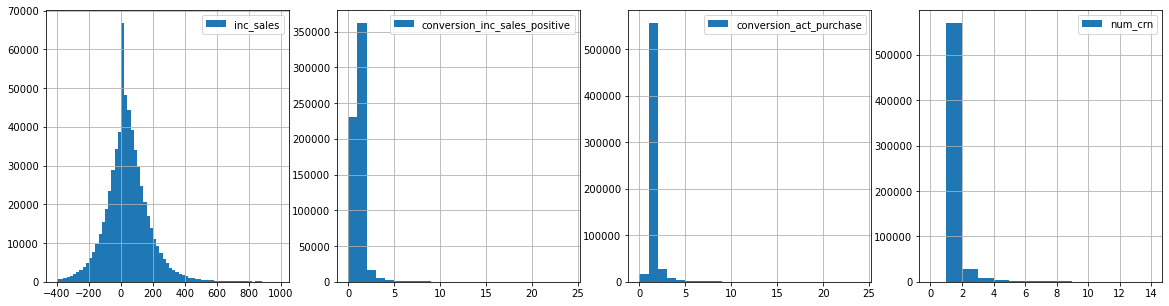

In [9]:
plt.subplot(1, 4, 1)
df.inc_sales.hist(figsize=(20,5), bins=[20 * x for x in range(-20, 50)], legend=1)
plt.subplot(1, 4, 2)
df.conversion_inc_sales_positive.hist(figsize=(20,5), bins=[1 * x for x in range(0, 25)], legend=1)
plt.subplot(1, 4, 3)
df.conversion_act_purchase.hist(figsize=(20,5), bins=[1 * x for x in range(0, 25)], legend=1)
plt.subplot(1, 4, 4)
df.num_crn.hist(figsize=(20,5), bins=[1 * x for x in range(0, 15)], legend=1)

## Running MC MTA

### Conversion := positive inc sales

In [10]:
start_time = time.time()
ca_conv_pos_inc_sales = mta.ca_from_journey(cj_df=df,
                                       var_path='path',
                                       var_conv='conversion_inc_sales_positive',
                                       var_null='non_conversion_inc_sales_positive',
                                       var_value='inc_sales',
                                       order=1)
print("run time", time.time() - start_time)
ca_conv_pos_inc_sales.sort_values("channel_name", inplace=True)
pd.options.display.max_rows = 25
ca_conv_pos_inc_sales 

Number of simulations: 100000 - Convergence reached: 2.90% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (35) is reached: 99.28%
run time 28.30684804916382


channel_name  total_conversions  \
1     CAT-4003_2021-01-28_activated_purchase       15398.617832   
0             CAT-4003_2021-01-28_activation       22665.981713   
2             CAT-4003_2021-01-28_redemption       13964.738439   
94  CAT-4003_2021-01-28_unactivated_purchase        5584.114159   
11    CAT-4031_2021-02-02_activated_purchase       15888.452407   
..                                       ...                ...   
55  TBR-4103_2021-02-01_unactivated_purchase         694.674489   
64    TBR-4303_2021-02-09_activated_purchase        1318.100312   
62            TBR-4303_2021-02-09_activation        1211.227314   
74            TBR-4303_2021-02-09_redemption         320.618995   
61  TBR-4303_2021-02-09_unactivated_purchase        1042.011733   

    total_conversion_value  normalised_conversion_value  
1             8.015690e+05                     0.029544  
0             1.264095e+06                     0.046591  
2             7.542090e+05                     0.027798  
94            2.755063e+05                     0.010154  
11            8.434468e+05                     0.031087  
..                     ...                          ...  
55            3.245222e+04                     0.001196  
64            7.311339e+04                     0.002695  
62            6.229436e+04                     0.002296  
74            1.504947e+04                     0.000555  
61            5.276151e+04                     0.001945  

[97 rows x 4 columns]

### Conversion := activate purchase

In [11]:
start_time = time.time()
ca_conv_act_purchase = mta.ca_from_journey(cj_df=df,
                                       var_path='path',
                                       var_conv='conversion_act_purchase',
                                       var_null='non_conversion_act_purchase',
                                       var_value='inc_sales',
                                       order=1)
print("run time", time.time() - start_time)
ca_conv_act_purchase.sort_values("channel_name", inplace=True)
pd.options.display.max_rows = 25
ca_conv_act_purchase 

Number of simulations: 100000 - Convergence reached: 2.09% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (35) is reached: 99.27%
run time 52.50264763832092


channel_name  total_conversions  \
1     CAT-4003_2021-01-28_activated_purchase       25041.423559   
0             CAT-4003_2021-01-28_activation       35292.141910   
2             CAT-4003_2021-01-28_redemption       21207.458281   
94  CAT-4003_2021-01-28_unactivated_purchase        8454.384970   
11    CAT-4031_2021-02-02_activated_purchase       25497.209640   
..                                       ...                ...   
55  TBR-4103_2021-02-01_unactivated_purchase        1126.059732   
64    TBR-4303_2021-02-09_activated_purchase        1876.766220   
62            TBR-4303_2021-02-09_activation        1867.829238   
74            TBR-4303_2021-02-09_redemption         446.849100   
61  TBR-4303_2021-02-09_unactivated_purchase        1832.081310   

    total_conversion_value  normalised_conversion_value  
1             8.756337e+05                     0.032274  
0             1.167418e+06                     0.043028  
2             6.268807e+05                     0.023105  
94            2.764430e+05                     0.010189  
11            8.536190e+05                     0.031462  
..                     ...                          ...  
55            3.749392e+04                     0.001382  
64            8.611655e+04                     0.003174  
62            8.882258e+04                     0.003274  
74           -1.991306e+03                    -0.000073  
61            7.797679e+04                     0.002874  

[97 rows x 4 columns]

## Results

### Results - grouped by Touchpoint

In [28]:
# join act purchase definition to pos inc sales definition
results = ca_conv_pos_inc_sales.join(ca_conv_act_purchase.loc[:, ["total_conversions", "total_conversion_value", "normalised_conversion_value"]], rsuffix='_act_purchase')

# extract campaign code
campaign_code = results.channel_name.str.extract(r'([A-Z]+-[0-9]{4})(_[a-bA-B])?', False).fillna("")
campaign_code.loc[:, "campaign_code"] = campaign_code.iloc[:, 0] + campaign_code.iloc[:, 1]
results.insert(0, "campaign", campaign_code.campaign_code)

# extract campaign date
campaign_date = results.channel_name.str.extract(r'([A-Z]+-[0-9]{4}_?[a-bA-B]?_[0-9]{4}-[0-9]{2}-[0-9]{2})', False).fillna("")
campaign_date
results.insert(0, "campaign_date", campaign_date)

# rounding to clean up values
for col in ["total_conversions", "total_conversion_value", "normalised_conversion_value", "total_conversions_act_purchase",
            "total_conversion_value_act_purchase", "normalised_conversion_value_act_purchase"]:
    if col.find("normalised") > -1:
        results.loc[:, col] = (results.loc[:, col] * 100).round(4)
    else:
        results.loc[:, col] = results.loc[:, col].round(2)

results.to_csv("04_results/results_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".csv")

results.sort_values("channel_name", inplace=True)
pd.options.display.max_rows = 20
results.to_csv("test.csv")
results

campaign_date  campaign                              channel_name  \
1   CAT-4003_2021-01-28  CAT-4003    CAT-4003_2021-01-28_activated_purchase   
0   CAT-4003_2021-01-28  CAT-4003            CAT-4003_2021-01-28_activation   
2   CAT-4003_2021-01-28  CAT-4003            CAT-4003_2021-01-28_redemption   
94  CAT-4003_2021-01-28  CAT-4003  CAT-4003_2021-01-28_unactivated_purchase   
11  CAT-4031_2021-02-02  CAT-4031    CAT-4031_2021-02-02_activated_purchase   
..                  ...       ...                                       ...   
55  TBR-4103_2021-02-01  TBR-4103  TBR-4103_2021-02-01_unactivated_purchase   
64  TBR-4303_2021-02-09  TBR-4303    TBR-4303_2021-02-09_activated_purchase   
62  TBR-4303_2021-02-09  TBR-4303            TBR-4303_2021-02-09_activation   
74  TBR-4303_2021-02-09  TBR-4303            TBR-4303_2021-02-09_redemption   
61  TBR-4303_2021-02-09  TBR-4303  TBR-4303_2021-02-09_unactivated_purchase   

    total_conversions  total_conversion_value  normalised_conversion_value  \
1            15398.62               801568.96                       2.9544   
0            22665.98              1264095.04                       4.6591   
2            13964.74               754209.05                       2.7798   
94            5584.11               275506.28                       1.0154   
11           15888.45               843446.80                       3.1087   
..                ...                     ...                          ...   
55             694.67                32452.22                       0.1196   
64            1318.10                73113.39                       0.2695   
62            1211.23                62294.36                       0.2296   
74             320.62                15049.47                       0.0555   
61            1042.01                52761.51                       0.1945   

    total_conversions_act_purchase  total_conversion_value_act_purchase  \
1                         25041.42                            875633.66   
0                         35292.14                           1167418.35   
2                         21207.46                            626880.66   
94                         8454.38                            276443.04   
11                        25497.21                            853618.96   
..                             ...                                  ...   
55                         1126.06                             37493.92   
64                         1876.77                             86116.55   
62                         1867.83                             88822.58   
74                          446.85                             -1991.31   
61                         1832.08                             77976.79   

    normalised_conversion_value_act_purchase  
1                                     3.2274  
0                                     4.3028  
2                                     2.3105  
94                                    1.0189  
11                                    3.1462  
..                                       ...  
55                                    0.1382  
64                                    0.3174  
62                                    0.3274  
74                                   -0.0073  
61                                    0.2874  

[97 rows x 9 columns]

### Results grouped by campaign

In [13]:
results_grouped = results.groupby(["campaign_date"]).sum()

# extract campaign code
campaign_code = pd.Series(results_grouped.index).str.extract(r'([A-Z]+-[0-9]{4})(_[a-bA-B])?', False).fillna("")
campaign_code.loc[:, "campaign_code"] = campaign_code.iloc[:, 0] + campaign_code.iloc[:, 1]

results_grouped = results_grouped.reset_index()
results_grouped.insert(0, "campaign", campaign_code.campaign_code)

# join on campaign info
results_grouped = results_grouped.merge(campaign_info.loc[:, ["cmpgn_code", "description", "cmpgn_type", "cmpgn_id"]], how='left', left_on='campaign', right_on='cmpgn_code').drop('cmpgn_code', axis=1)

pd.options.display.max_rows = 20
results_grouped

campaign        campaign_date  total_conversions  total_conversion_value  \
0   CAT-4003  CAT-4003_2021-01-28           57613.45              3095379.33   
1   CAT-4031  CAT-4031_2021-02-02           44476.98              2376729.97   
2   CAT-4105  CAT-4105_2021-02-09           53774.93              2913759.82   
3   CNA-0005  CNA-0005_2021-02-08           11658.07               669494.00   
4   CVM-0007  CVM-0007_2021-02-01           21143.05              1153534.89   
..       ...                  ...                ...                     ...   
21  OSP-4079  OSP-4079_2021-02-10           14632.70               816597.30   
22  OSP-4102  OSP-4102_2021-02-10           10714.02               570652.34   
23  PBU-4073  PBU-4073_2021-02-08            7080.34               380135.64   
24  TBR-4103  TBR-4103_2021-02-01            9387.01               494080.13   
25  TBR-4303  TBR-4303_2021-02-09            3891.96               203218.73   

    normalised_conversion_value  total_conversions_act_purchase  \
0                       11.4087                        89995.40   
1                        8.7600                        70888.14   
2                       10.7393                        83560.77   
3                        2.4675                        19071.52   
4                        4.2516                        32602.11   
..                          ...                             ...   
21                       3.0099                        23665.13   
22                       2.1033                        17650.54   
23                       1.4011                        11135.47   
24                       1.8211                        16175.94   
25                       0.7491                         6023.53   

    total_conversion_value_act_purchase  \
0                            2946375.71   
1                            2266528.58   
2                            2928011.75   
3                             646655.52   
4                            1103937.68   
..                                  ...   
21                            839909.12   
22                            611563.60   
23                            401753.70   
24                            608890.22   
25                            250924.61   

    normalised_conversion_value_act_purchase  \
0                                    10.8596   
1                                     8.3538   
2                                    10.7919   
3                                     2.3834   
4                                     4.0689   
..                                       ...   
21                                    3.0957   
22                                    2.2540   
23                                    1.4808   
24                                    2.2442   
25                                    0.9249   

                                          description cmpgn_type  cmpgn_id  
0                      International Foods Multiplier    stretch   22531.0  
1                          WW BBQ Feb 2021 Multiplier    stretch   22831.0  
2                  February Meat program week 1 and 2    stretch   23125.0  
3   Campaign notifying members when they have hit ...    stretch      39.0  
4   Campaign designed to increase customer spend a...    stretch       1.0  
..                                                ...        ...       ...  
21                                    Mr Chens 5x pts    stretch   23059.0  
22                                   Pepsi Max 5x pts    stretch   23060.0  
23  All opted in Bupa - linked members will  Earn ...    stretch   22960.0  
24                             EDR+ February Boosters    stretch   22729.0  
25          EDR+ Project Barry - Team Member Giveaway    stretch   22927.0  

[26 rows x 11 columns]

## Compare with Safari GT

In [14]:
# grab data from GCP
if REDOWNLOAD_FROM_GCP:
    # grab data from GCP
    !rm -f 02_data/safari_campaign_inc_sales*.csv
    !gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/safari_campaign_inc_sales*.csv 02_data/

Copying gs://wx-personal/AndrewLau/nash/MC_POC/safari_campaign_inc_sales000000000000.csv...
/ [1 files][  1.7 KiB/  1.7 KiB]                                                
Operation completed over 1 objects/1.7 KiB.                                      


In [15]:
safari_campaign_inc_sales = pd.read_csv("02_data/safari_campaign_inc_sales000000000000.csv")
safari_campaign_inc_sales.loc[:, "campaign_date"] = safari_campaign_inc_sales.campaign_code + "_" + safari_campaign_inc_sales.campaign_start_date
safari_campaign_inc_sales

fw_start_date    pph campaign_code campaign_start_date  num_CRN  \
0     2021-02-08  promo      CAT-4003          2021-01-28   258989   
1     2021-02-08  promo      CAT-4031          2021-02-02    24482   
2     2021-02-08  promo      CAT-4105          2021-02-09   189316   
3     2021-02-08  promo      CNA-0005          2021-02-08    16462   
4     2021-02-08  promo      CVM-0007          2021-02-01    89451   
..           ...    ...           ...                 ...      ...   
22    2021-02-08  promo      OSP-4079          2021-02-10     5189   
23    2021-02-08  promo      OSP-4102          2021-02-10     6171   
24    2021-02-08  promo      PBU-4073          2021-02-08    25246   
25    2021-02-08  promo      TBR-4103          2021-02-01    52175   
26    2021-02-08  promo      TBR-4303          2021-02-09     4174   

       inc_sales        campaign_date  
0  -5.777302e+04  CAT-4003_2021-01-28  
1   1.921451e+05  CAT-4031_2021-02-02  
2   6.352156e+06  CAT-4105_2021-02-09  
3   6.072851e+05  CNA-0005_2021-02-08  
4   3.482327e+05  CVM-0007_2021-02-01  
..           ...                  ...  
22  1.498900e+05  OSP-4079_2021-02-10  
23  1.536450e+05  OSP-4102_2021-02-10  
24  3.325492e+05  PBU-4073_2021-02-08  
25 -2.362949e+05  TBR-4103_2021-02-01  
26  6.331170e+04  TBR-4303_2021-02-09  

[27 rows x 7 columns]

In [17]:
# results_grouped_GT = results_grouped.merge(safari_campaign_inc_sales.loc[:, ["campaign_date", "pph", "num_CRN", "inc_sales", "redemptions"]], how='left', left_on='campaign_date', right_on='campaign_date')
results_grouped_GT = results_grouped.merge(safari_campaign_inc_sales.loc[:, ["campaign_date", "pph", "num_CRN", "inc_sales"]], how='left', left_on='campaign_date', right_on='campaign_date')
results_grouped_GT.loc['Column_Total'] = results_grouped_GT.sum(numeric_only=True, axis=0)

results_grouped_GT = results_grouped_GT.copy()
results_grouped_GT.loc[:, "MMM_flag"] = "Not-MMM_"
results_grouped_GT.loc[results_grouped_GT.campaign.isin(['CVM-0106', 'CVM-0108', 'CVM-0007', 'CVM-3509', 'CVM-3510', 'CVM-3525', 'CVM-3529']), "MMM_flag"] = "MMM_"
results_grouped_GT.loc[:, "Campaign"] = results_grouped_GT.MMM_flag + results_grouped_GT.campaign_date

results_grouped_GT.to_csv("04_results/results_grouped_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".csv")
results_grouped_GT.head(10)

campaign        campaign_date  total_conversions  total_conversion_value  \
0  CAT-4003  CAT-4003_2021-01-28           57613.45              3095379.33   
1  CAT-4031  CAT-4031_2021-02-02           44476.98              2376729.97   
2  CAT-4105  CAT-4105_2021-02-09           53774.93              2913759.82   
3  CNA-0005  CNA-0005_2021-02-08           11658.07               669494.00   
4  CVM-0007  CVM-0007_2021-02-01           21143.05              1153534.89   
5  CVM-0056  CVM-0056_2021-02-01              53.44                 1078.31   
6  CVM-0106  CVM-0106_2021-02-01           11827.27               608096.15   
7  CVM-0108  CVM-0108_2021-01-18            6528.16               325251.28   
8  CVM-0108  CVM-0108_2021-02-01            3963.21               213347.14   
9  CVM-3510  CVM-3510_2021-02-01            2297.77               139789.05   

   normalised_conversion_value  total_conversions_act_purchase  \
0                      11.4087                        89995.40   
1                       8.7600                        70888.14   
2                      10.7393                        83560.77   
3                       2.4675                        19071.52   
4                       4.2516                        32602.11   
5                       0.0040                           44.68   
6                       2.2412                        19375.38   
7                       1.1988                         9857.50   
8                       0.7863                         6372.07   
9                       0.5152                         3261.99   

   total_conversion_value_act_purchase  \
0                           2946375.71   
1                           2266528.58   
2                           2928011.75   
3                            646655.52   
4                           1103937.68   
5                               144.24   
6                            597375.48   
7                            383050.28   
8                            203616.91   
9                            136431.75   

   normalised_conversion_value_act_purchase  \
0                                   10.8596   
1                                    8.3538   
2                                   10.7919   
3                                    2.3834   
4                                    4.0689   
5                                    0.0005   
6                                    2.2018   
7                                    1.4118   
8                                    0.7504   
9                                    0.5028   

                                         description cmpgn_type  cmpgn_id  \
0                     International Foods Multiplier    stretch   22531.0   
1                         WW BBQ Feb 2021 Multiplier    stretch   22831.0   
2                 February Meat program week 1 and 2    stretch   23125.0   
3  Campaign notifying members when they have hit ...    stretch      39.0   
4  Campaign designed to increase customer spend a...    stretch       1.0   
5                                     Low Active CDA    stretch     306.0   
6  Spend $XX in Week 1 and Week 2 to get YYYY bon...    stretch    1335.0   
7  CDA Continuity 4 Weeks - Spend $XX in Week 1, ...    stretch    1337.0   
8  CDA Continuity 4 Weeks - Spend $XX in Week 1, ...    stretch    1337.0   
9                    3 Week Multiplier- HV Retention    stretch   15601.0   

     pph   num_CRN     inc_sales  MMM_flag                     Campaign  
0  promo  258989.0 -5.777302e+04  Not-MMM_  Not-MMM_CAT-4003_2021-01-28  
1  promo   24482.0  1.921451e+05  Not-MMM_  Not-MMM_CAT-4031_2021-02-02  
2  promo  189316.0  6.352156e+06  Not-MMM_  Not-MMM_CAT-4105_2021-02-09  
3  promo   16462.0  6.072851e+05  Not-MMM_  Not-MMM_CNA-0005_2021-02-08  
4  promo   89451.0  3.482327e+05      MMM_      MMM_CVM-0007_2021-02-01  
5  promo     403.0  2.696818e+04  Not-MMM_  Not-MMM_CVM-0056_2021-02-01  
6  promo   64613.0  4.900221e+05      MMM_      MMM_CVM-010

# Scaling and results

In [23]:
results_for_corr = results_grouped_GT.copy()

# results_for_corr = results_for_corr.drop("Column_Total", axis=0).set_index("Campaign").loc[:, ["inc_sales", "total_conversion_value_act_purchase", "redemptions"]]
results_for_corr = results_for_corr.drop("Column_Total", axis=0).set_index("Campaign").loc[:, ["inc_sales", "total_conversion_value_act_purchase"]]
results_for_corr = results_for_corr.rename(columns={"inc_sales":"Game Theory", "total_conversion_value_act_purchase":"MC POC"})
MC_POC_scaling = sum(results_for_corr.loc[:, "Game Theory"]) / sum(results_for_corr.loc[:, "MC POC"])
results_for_corr.loc[:, "MC POC"] = results_for_corr.loc[:, "MC POC"] * MC_POC_scaling
results_for_corr = results_for_corr.sort_index()
print("MC POC scaling is", MC_POC_scaling)

MC POC scaling is 0.8530855099089873


In [24]:
print("Correlation between MC and GT output is", round(pearsonr(results_for_corr.iloc[:, 0], results_for_corr.iloc[:, 1])[0], 2))

Correlation between MC and GT output is 0.72


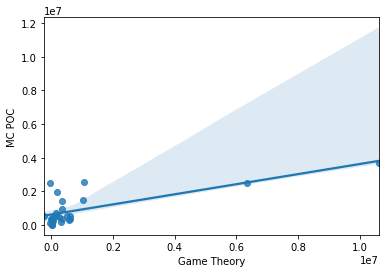

In [25]:
sns.regplot(x="Game Theory", y="MC POC", data=results_for_corr, ci=90)
plt.savefig("04_results/results_grouped_scatterplot_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".png")

In [29]:
results_for_corr.to_csv('test.csv')

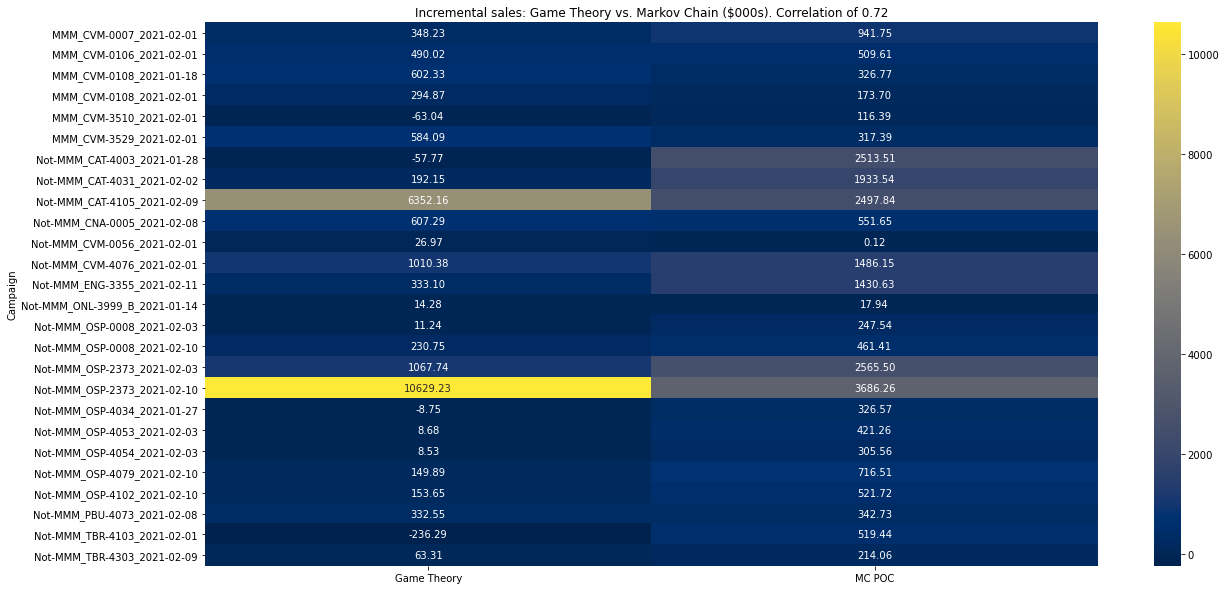

In [27]:
from matplotlib.ticker import FuncFormatter
plt.subplots(figsize=(20, 10))
plt.title("Incremental sales: Game Theory vs. Markov Chain ($000s). Correlation of "+ str(round(pearsonr(results_for_corr.iloc[:, 0], results_for_corr.iloc[:, 1])[0], 2)))

sns.heatmap(results_for_corr / 1000, cmap='cividis', annot=True, fmt=".2f")
plt.savefig("04_results/results_grouped_heatmap_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".png")